# Practice with galaxy photometry and shape measurement
To accompany galaxy-measurement lecture from the LSSTC Data Science Fellowship Program, July 2020.

All questions and corrections can be directed to me at garyb@physics.upenn.edu

Enjoy!

_Gary Bernstein, 16 July 2020_

In [1]:
# Load the packages we will use
import numpy as np
import astropy.io.fits as pf
import astropy.coordinates as co
from matplotlib import pyplot as pl
import scipy.fft as fft
%matplotlib inline

## Useful tools
For our galaxy measurement practice, we'll be testing out some of our techniques on *exponential profile* galaxies, which are define by
$$ I(x,y) \propto e^{-r/r_0},$$
where $r_0$ is the "scale length," and we'll allow our galaxy to potentially be elliptical shaped by setting
$$ r^2 = (1-e^2) \left[ \frac{(x-x_0)^2}{1-e} + \frac{(y-y_0)^2}{1+e}\right].$$

To reduce the complexity of our problem, I'm only letting the galaxy have the $e_+$ form of ellipticity, where $e>0$ ($e<0$) means the galaxy is stretched along the $x$ ($y$) axis.

We're also going to assume that our galaxy is viewed through a circular Gaussian PSF:
$$ T(x,y) \propto e^{-(x^2+y^2)/2\sigma_{\rm PSF}^2}.$$

The function `drawDisk` below is provided to draw an image of an elliptical exponential galaxy as convolved with a Gaussian PSF.  You don't have to understand how it works to do these exercises.  But you might be interested (since this is how the `GalSim` galaxy simulation package works): the galaxy and the PSF are first "drawn" in Fourier space, and then multiplied, since a convolution in real space is multiplication in Fourier space (which is *much* faster).  Then we use a Fast Fourier Transform (FFT) to get our image back in real space.

I also include in this notebook two helpful things from the astrometry notebook:
* The function `addBackground` which will add background noise of a chosen level (denoted as $n$ in the lecture notes) to any image.
* The `x` and `y` arrays that give the location values of each pixel. In this set of exercises, we'll work exclusively with 64x64 images.  Also I am going to redefine the coordinate system so that $(x,y)=(0,0)$ is actually at element `[32,32]` of the array.

In [2]:
def addBackground(image, variance):
    # Add Gaussian noise with given variance to each pixel of the image
    image += np.random.normal(scale=np.sqrt(variance),size=image.shape)
    return

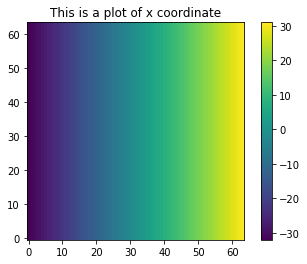

In [3]:
n_pix = 64
xy=np.indices( (n_pix,n_pix),dtype=float)
x = xy[1].copy()- n_pix/2
y = xy[0].copy()- n_pix/2
pl.imshow(x,origin='lower',interpolation='nearest')
pl.title("This is a plot of x coordinate")
pl.colorbar()

In [4]:
# Here is our elliptical exponential galaxy drawing function
# It is always centered on the pixel just above right of the image center.
def drawDisk(r0=4.,flux=1.,e=0.,sigma_psf=3.,n_pix=n_pix):
    # n_pix must be even.
    
    # Build arrays holding the (ky,kx) values
    # irfft2 wants array of this shape:
    tmp = np.ones((n_pix,n_pix//2+1),dtype=float) 
    freqs = np.arange(-n_pix//2,n_pix//2)
    freqs = (2 * np.pi / n_pix)*np.roll(freqs,n_pix//2)
    kx = tmp * freqs[:n_pix//2+1]
    ky = tmp * freqs[:,np.newaxis]

    # Calculate the FT of the PSF
    ft = np.exp( (kx*kx+ky*ky)*(-sigma_psf*sigma_psf/2.))
    
    # Produce the FT of the exponential - for the circular version,
    # it's (1+k^2 r_0^2)**(-3/2)
    # factors to "ellipticize" and scale the k's:
    a = np.power((1+e)/(1-e),0.25)
    ksqp1 = np.square(r0*kx*a) + np.square(r0*ky/a) + 1
    ft *= flux / (ksqp1*np.sqrt(ksqp1))
    
    # Now FFT back to real space
    img = fft.irfft2(ft)
    # And roll the origin to the center
    return np.roll(img, (n_pix//2,n_pix//2),axis=(0,1))
    

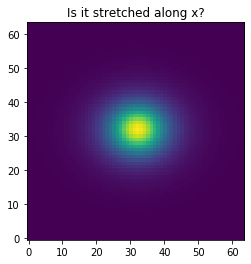

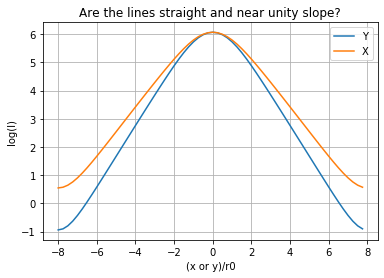

In [5]:
# As a test, let's draw an image with a small PSF size and
# see if it really is exponential. 
# With e>0, it should be extended along x axis
r0=4.
img = drawDisk(e=0.2,flux=1e5,sigma_psf=3.,r0=r0)
pl.imshow(img,origin='lower',interpolation='nearest')
pl.title("Is it stretched along x?")
# And also a plot of log(flux) vs x or y should look linear
pl.figure()
pl.plot(np.arange(-32,32)/r0,np.log(img[:,32]),label='Y')
pl.plot(np.arange(-32,32)/r0,np.log(img[32,:]),label='X')
pl.legend()
pl.title("Are the lines straight and near unity slope?")
pl.xlabel("(x or y)/r0")
pl.ylabel("log(I)")
pl.grid()

## Exercise 1: Aperture photometry

Here we'll try out a few forms of aperture photometry and see how they compare in terms of the S/N ratios they provide on the galaxy flux.

**(a)** Write a function `tophat_flux(img,R)` which implements a simple tophat aperture sum of flux in all pixels within radius `R` of the center of the galaxy.  We will keep the center of our galaxy fixed at pixel \[32,32\] so you don't have to worry about iterating to find the centroid.

Draw a noiseless version of a circular galaxy with the characteristics in the cell below.  Then use your `tophat_flux` function to plot the "curve of growth" for this image, with `R` on the x axis going from 5 to 30 pixels, and the y axis showing the fraction of the total flux that falls in your aperture.

How many scale radii do we need the aperture to be to miss <1% of the flux?

In [6]:
r0 = 4.
e = 0.
flux = 1e4
sigma_psf = 2.

In [7]:
# First construct a weight-function class for tophat
class Tophat:
    # A tophat weight function of radius sigma
    def __init__(self,R):
        self.R = R
        return
    def __call__(self,dx,dy):
        # Given equal-shaped arrays dx=x-x0, dy=y-y0,
        # returns an array of the same shape giving weight function.

        # Calculate distance of a pixel from the center
        rsq = np.square(dx) + np.square(dy)
    
        # Now return the weight
        return np.where(rsq<=self.R*self.R, 1., 0.)
    
# Now I'm going to write a generic aperture_flux instead of tophat_flux
def aperture_flux(img, weight, x=x, y=y, x0=0., y0=0.):
    # Return aperture flux sum of image given weight function.
    # x and y are coordinates assigned to each array element.
    # x0,y0 are center of aperture.  Which in this exercise will
    # be zero sinze x and y are already centered.
    
    # Super-simple!
    return np.sum(img*weight(x,y))

Aperture radius / scale length for >99% of flux: 6.75


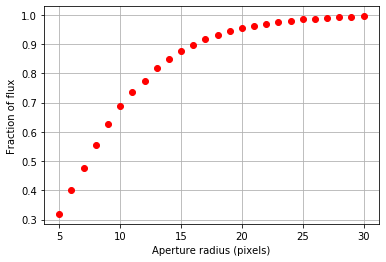

In [8]:
star = drawDisk(r0=r0, e=e, flux=flux,sigma_psf=sigma_psf)
Rlist = np.arange(5,30.1,1.)
flux_fraction = []
for R in Rlist:
    weight = Tophat(R)
    flux_fraction.append(aperture_flux(star,weight) / flux)

pl.plot(Rlist, flux_fraction,'ro')
pl.xlabel('Aperture radius (pixels)')
pl.ylabel('Fraction of flux')
pl.grid()

index_99 = np.where(np.array(flux_fraction)>0.99)[0][0]
print('Aperture radius / scale length for >99% of flux:',Rlist[index_99] / r0)

**(b)** Next let's add some background noise to our image, say `n_bg=100`.  
* First, make one such noisy version of your galaxy and `imshow` it.  
* Then, using **analytic** methods, estimate what the variance of your aperture flux measurements will be when `R=10`.  
* Finally, make 1000 different realizations of your noisy galaxy and measure their `tophat_flux` to see whether the real variance of the flux measurements matches your prediction.


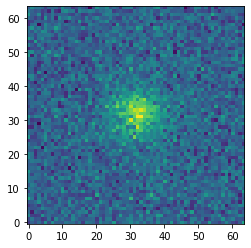

In [9]:
# Make our noiseless galaxy image
noiseless = drawDisk(r0=r0,e=e,flux=flux,sigma_psf=sigma_psf)

# Add noise to ity
noisy = noiseless.copy()
n_bg = 100
addBackground(noisy,variance=n_bg)

# show it
pl.imshow(noisy,origin='lower',interpolation='nearest')

Since the variance of each pixel is `n_bg`$=n$, the variance of our aperture flux, generically, is
$$ \textrm{Var}(f) = \textrm{Var} \sum_{xy} I_{xy} W(x,y) = \sum_{xy} W^2(x,y) \textrm{Var}(I_{xy}) = n \sum_{xy} W^2(x,y).$$
So we just need to get that last sum, which is just the number of pixels inside the aperture for the tophat.


In [10]:
weight = Tophat(10.)
expected_variance = n_bg * np.sum(np.square(weight(x,y)))
print('Analytic variance: ',expected_variance)

Analytic variance:  31700.0


In [11]:
# Now measure a pile of images with the same weight function.
# I'll use the same noiseless star and keep adding fresh noise to it.
fluxes = []
nTrials = 1000
for i in range(nTrials):
    noisy = noiseless.copy()
    addBackground(noisy,variance=n_bg)
    fluxes.append(aperture_flux(noisy,weight))

print("Empirical variance:",np.var(fluxes))


Empirical variance: 31177.717469983472


**(c)** Now create a plot of the S/N level of the flux measurement vs the radius `R` of the aperture.  Here the signal is the mean, and the noise the std deviation, of the `tophat_flux` of many noisy measurements of this galaxy.  You can use either an analytic or numeric estimate of these quantities.  Report what the optimal tophat S/N is, and what `R` achieves it.

Best S/N is 39.455276177455474 at aperture radius 8.0


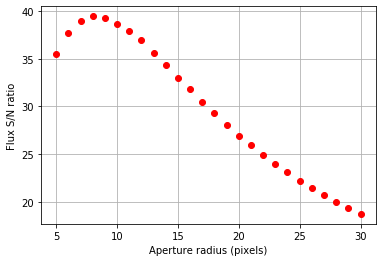

In [12]:
# I'll go with the analytic variance since that seems to work and it will 
# be faster.
# I have the noiseless measured fluxes already in the flux_fraction array.
sn_ratio = []
for R,f in zip(Rlist,flux_fraction):
    weight = Tophat(R)
    expected_variance = n_bg * np.sum(np.square(weight(x,y)))
    sn_ratio.append( f * flux / np.sqrt(expected_variance))
    
# Now plot the results
pl.plot(Rlist, sn_ratio,'ro')
pl.xlabel('Aperture radius (pixels)')
pl.ylabel('Flux S/N ratio')
pl.grid()

# Where's the best?
i = np.argmax(sn_ratio)
print("Best S/N is",sn_ratio[i],"at aperture radius",Rlist[i])

**(d)** Repeat part (c), but this time use a *Gaussian* aperture whose width $\sigma_w$ you vary to optimize the S/N ratio of the aperture flux, i.e. a function `gaussian_flux(img,sigma_w)` is needed.  Which performs better, the optimized tophat or the optimized Gaussian?

Best S/N is 45.173351977346634 at aperture sigma 5.25


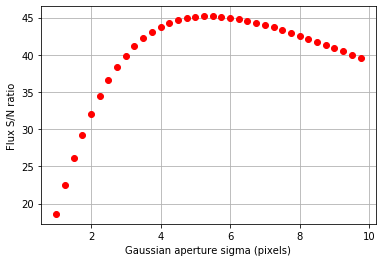

In [13]:
# I can do this quickly by making a Gaussian Aperture class and plugging it into 
# my aperture_flux code
class GaussAp:
    # A tophat weight function of radius sigma
    def __init__(self,sigma):
        self.sigma = sigma
        return
    def __call__(self,dx,dy):
        # Given equal-shaped arrays dx=x-x0, dy=y-y0,
        # returns an array of the same shape giving weight function.

        # Calculate distance of a pixel from the center
        rsq = np.square(dx) + np.square(dy)
    
        # Now return the weight
        return np.exp(-rsq/(2.*self.sigma*self.sigma))

sigma_list = np.arange(1.0,10.,0.25)
sn_ratio = []
for s in sigma_list:
    weight = GaussAp(s)
    gauss_flux = aperture_flux(noiseless,weight)
    expected_variance = n_bg * np.sum(np.square(weight(x,y)))
    sn_ratio.append( gauss_flux / np.sqrt(expected_variance))
    
# Now plot the results
pl.plot(sigma_list, sn_ratio,'ro')
pl.xlabel('Gaussian aperture sigma (pixels)')
pl.ylabel('Flux S/N ratio')
pl.grid()

# Where's the best?
i = np.argmax(sn_ratio)
print("Best S/N is",sn_ratio[i],"at aperture sigma",sigma_list[i])

# The Gaussian aperture yields about 15% higher S/N, equivalent to 30% more exposure time!

## Exercise 2: Spurious color

This time let's consider that we want to measure an accurate $g-r$ color for our galaxy, but the seeing is $\sigma_{\rm PSF}=2$ pixels in the $r$ image but $\sigma_{\rm PSF}=2.5$ pixels in the $g$ image.  Let's see how the size of our aperture biases our color measurement.

**(a)** Draw a noiseless $g$-band and a noiseless $r$-band image of our galaxy.  Let's assume that the true color $g-r \equiv 2.5\log_10(f_r/f_g) = 0,$ i.e. that the $g$ and $r$ fluxes of the galaxy are both equal to our nominal `flux`.  Plot the difference between the two images: are they the same?

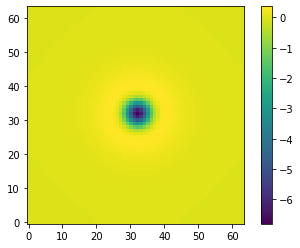

In [14]:
img_g = drawDisk(r0=r0,e=e,flux=flux,sigma_psf=2.5)
img_r = drawDisk(r0=r0,e=e,flux=flux,sigma_psf=2.0)
pl.imshow(img_g-img_r,origin='lower',interpolation='nearest')
pl.colorbar()

**(b)** Using either your Gaussian or your tophat aperture code, plot the *measured* $g-r$ color of the galaxy as a function of the size of the aperture.  Since the true color is zero, this measurement is the size of the systematic error that is being made in color because of mismatched *pre-seeing* apertures.

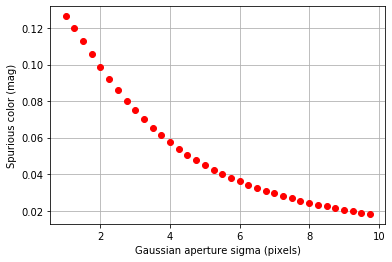

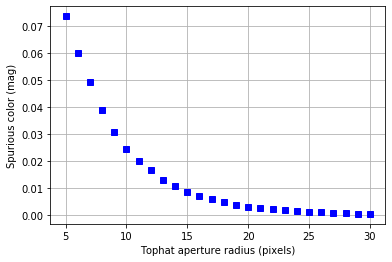

In [15]:
#I'll plot Gaussian apertures since they got better S/N

# Use our 2 noiseless images
color = []
for s in sigma_list:
    weight = GaussAp(s)
    flux_g = aperture_flux(img_g,weight)
    flux_r = aperture_flux(img_r,weight)
    color.append(-2.5*np.log10(flux_g/flux_r))
    
# Now plot the results
pl.plot(sigma_list, color,'ro')
pl.xlabel('Gaussian aperture sigma (pixels)')
pl.ylabel('Spurious color (mag)')
pl.grid()

# What the heck, let's do Tophats too:
pl.figure()
color = []
for R in Rlist:
    weight = Tophat(R)
    flux_g = aperture_flux(img_g,weight)
    flux_r = aperture_flux(img_r,weight)
    color.append(-2.5*np.log10(flux_g/flux_r))
    
# Now plot the results
pl.plot(Rlist, color,'bs')
pl.xlabel('Tophat aperture radius (pixels)')
pl.ylabel('Spurious color (mag)')
pl.grid()


We can see here that a naive use of "matched" apertures can cause significant spurious color, even when the aperture has a sigma that is many times that of the galaxy and PSF. But the tophat does better.  So without any kind of PSF matching, we have to use algorithms with non-optimal S/N in order to approach true colors.

## Exercise 3: Degradation of ellipticity measurements by seeing

It's hard to measure the shape of a galaxy that is not resolved by the PSF.  That means that poorly-resolved galaxies are less useful for detecting weak-lensing (WL) shear.  Let's see if we can quantify this by using the Fisher matrix to determine the best possible measurement accuracy on the parameter $e$ of our model (we'll make things easy by holding all other parameters of the galaxy model as fixed).

Remember how the Fisher matrix works: for an image signal $I_{xy}$ and noise $\sigma_{xy}$ in each pixel, the Fisher information for a parameter $\theta$ is
$$ F_{\theta\theta} = \sum_{xy} \frac{1}{\sigma^2_{xy}} \left(\frac{\partial I_{xy}}{\partial\theta}\right)^2.$$

Here we're interested in $\theta=e$.

**(a)** Draw two versions of our standard galaxy, with $e = \pm0.01.$  Use these to calculate and plot the quantity we need, $\frac{\partial I_{xy}}{\partial e}.$  Comment on how this picture relates to the fact that we like to measure WL shear using the moment of $x^2-y^2$.

Text(0.5, 1.0, 'dI/de')

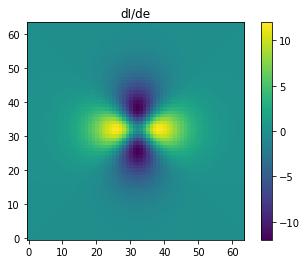

In [16]:
de = 0.01
img1 = drawDisk(r0=r0,flux=flux,sigma_psf=sigma_psf,e=+de)
img2 = drawDisk(r0=r0,flux=flux,sigma_psf=sigma_psf,e=-de)
dI_de = (img1-img2)/(2*de)
pl.imshow(dI_de,origin='lower',interpolation='nearest')
pl.colorbar()
pl.title('dI/de')

# Look at that! The signature of WL shear is a quadrupole pattern, which is matched
# and therefore picked out of an image by the (x^2-y^2) moment!

**(b)** Use this to calculate the best achievable measurement accuracy on $e$ for our standard image.

In [17]:
# We take the Fisher sum
Fee = np.sum(dI_de * dI_de) / n_bg
# ...and then the Cramer-Rao bound on sigma_e is
print("Lower bound on sigma_e:",1./np.sqrt(Fee))

Lower bound on sigma_e: 0.05911571839184263


**(c)** Make a graph showing how the optimal $\sigma_e$ varies as the size $\sigma_{\rm PSF}$ of the Gaussian PSF varies from being $0.2\times r_0$ to being $3\times r_0.$.  What's the lesson here?

Text(4.0, 0.25, 'Scale length')

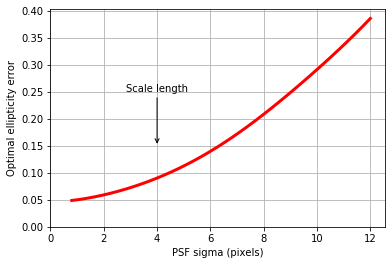

In [18]:
# I want to wrap all of the above into a function of sigma_psf:
def sigma_opt(sigma_psf):
    de = 0.01
    img1 = drawDisk(r0=r0,flux=flux,sigma_psf=sigma_psf,e=+de)
    img2 = drawDisk(r0=r0,flux=flux,sigma_psf=sigma_psf,e=-de)
    dI_de = (img1-img2)/(2*de)
    Fee = np.sum(dI_de * dI_de) / n_bg
    return 1./np.sqrt(Fee)

# Now make our plot
psfs = np.linspace(0.2*r0,3*r0,40)

# use our function to get results
sigma_e = [sigma_opt(sigma_psf) for sigma_psf in psfs]

# And plot
pl.plot(psfs,sigma_e,'r-',lw=3)
pl.xlabel("PSF sigma (pixels)")
pl.ylabel('Optimal ellipticity error')
pl.ylim(0)
pl.xlim(0)
pl.grid()
pl.annotate('Scale length',(r0,0.15),xytext=(r0,0.25),ha='center',
           arrowprops={'arrowstyle':'->'})

Our lesson is that one pays dearly in ellipticity measurement noise galaxies comparable to or smaller than the PSF size!  Both random and systematic errors grow for small galaxies, so they should be ignored or downweighted in a WL analysis.